In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
import os
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

#导入数据
# housedata=fetch_california_housing()
#划分测试集和训练集
# df_train= pd.read_csv('/home/ysy/ysy/Fed-ReKD-dirs/all.csv')
# x = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1).values
# y = df_train['logerror'].values
# train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.1,random_state=42)
#划分测试集和训练集
process_dataset_x= pd.read_csv('/home/ysy/ysy/Fed-ReKD-dirs/process_dataset_x.csv',index_col=0)
process_dataset_y= pd.read_csv('/home/ysy/ysy/Fed-ReKD-dirs/process_dataset_y.csv',index_col=0)
x = process_dataset_x
y = process_dataset_y['logerror']
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.1,random_state=42)
from sklearn.preprocessing import StandardScaler
#标准化处理
scale=StandardScaler()
train_x=scale.fit_transform(train_x)
test_x=scale.fit_transform(test_x)
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape,max(train_y),min(train_y),max(test_y),min(test_y))
del x,y

/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(148084, 81) (148084,) (16454, 81) (16454,) 0.428162348933 -0.400350158603 0.425186135849 -0.399102826816


In [3]:
train_x=np.array(train_x)
train_y=np.array(train_y)
test_x=np.array(test_x)
test_y=np.array(test_y)

In [4]:
# Split dataset
def split_list_n_list(origin_list, n):
    if len(origin_list) % n == 0:
        cnt = len(origin_list) // n
    else:
        cnt = len(origin_list) // n + 1
 
    for i in range(0, n):
        yield origin_list[i*cnt:(i+1)*cnt]

In [5]:
#preparing teacher's datasets
n_teachers=10
teacher_x,teacher_y = [],[]
teacher_datasets = []
teacher_data_loader = []



teacher_x_loder = split_list_n_list(train_x,n_teachers)
teacher_y_loder = split_list_n_list(train_y,n_teachers)

teacher_x.extend(iter(teacher_x_loder))
teacher_y.extend(iter(teacher_y_loder))

for i in range(n_teachers):
    print(i,teacher_x[i].shape,teacher_y[i].shape)


from torch.utils.data import TensorDataset, DataLoader
teacher_datasets.extend(TensorDataset(torch.tensor(teacher_x[u],device=device,dtype=torch.float),
                                       torch.tensor(teacher_y[u],device=device,dtype=torch.float))
                        for u in  range(n_teachers))

teacher_data_loader.extend(DataLoader(teacher_datasets[i],batch_size=128,shuffle=True)
                           for i in range(n_teachers))


    

0 (14809, 81) (14809,)
1 (14809, 81) (14809,)
2 (14809, 81) (14809,)
3 (14809, 81) (14809,)
4 (14809, 81) (14809,)
5 (14809, 81) (14809,)
6 (14809, 81) (14809,)
7 (14809, 81) (14809,)
8 (14809, 81) (14809,)
9 (14803, 81) (14803,)


In [6]:
#preparing student's dataset
student_x,student_y = [] ,[]
student_datasets= []
 

student_x_loder =  split_list_n_list(test_x,2)
student_y_loder =  split_list_n_list(test_y,2)
student_x.extend(iter(student_x_loder))
student_y.extend(iter(student_y_loder))

for i in range(2):
    print(i,student_x[i].shape,student_y[i].shape)

student_datasets.extend(
                        TensorDataset(torch.tensor(student_x[u],device=device,dtype=torch.float),
                                      torch.tensor(student_y[u],device=device,dtype=torch.float))
                        for u in range(2)
)

student_train_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]),shuffle=True)
student_test_loader = DataLoader(student_datasets[1], batch_size=len(student_datasets[1]))

samples= student_x[i].shape[0]
print(samples)

0 (8227, 81) (8227,)
1 (8227, 81) (8227,)
8227


In [8]:
#define metrics


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

import pyro
from pyro.distributions import Normal
from pyro.distributions import Categorical
from pyro.optim import Adam
from pyro.infer import SVI
from pyro.infer import Trace_ELBO

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape).to(device)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape).to(device)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)).to(device))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)).to(device))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        return F.linear(input, self.w, self.b)

class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden = Linear_BBB(81,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.tanh(self.hidden(x)).to(device)
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples ):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.reshape(-1).shape[0]).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_posts = torch.zeros(samples).to(device)
        log_likes = torch.zeros(samples).to(device)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1).to(device) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss =  log_post - log_prior  - log_like
        return loss

BNN = MLP_BBB(405, prior_var=1).to(device)
print(BNN)


MLP_BBB(
  (hidden): Linear_BBB()
  (out): Linear_BBB()
)


In [8]:
 
#training configs
num_epochs=600 #10*3000 15 2000
batch_size =128
lr =1e-3
#1e-3 n=15  200 0.05
#initializing  teachers model
teachers_model = []

for i in range(n_teachers):
    net = BNN
    teachers_model.append(net)
 
teacher_optimizers = [torch.optim.Adam(teachers_model[i].parameters(), lr=lr) for i in range(n_teachers)]

In [9]:
#creating teachers folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

for i in  range(n_teachers):
    mkdir_if_missing(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/teacher{i}')

In [12]:
#training teacher models
loss_func=nn.MSELoss()
train_loss_all=[]
# loss_all=[[0]*num_epochs]*n_teachers
for tea_num in range(n_teachers):
    print(f'start training number {tea_num} techer!')
    minloss =float ('inf')
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_num=0
        teachers_model[tea_num].train()
        for b_x,b_y in teacher_data_loader[tea_num]:
            teacher_optimizers[tea_num].zero_grad()
            output=teachers_model[tea_num].forward(b_x.to(device))
            loss=loss_func(output,b_y.to(device))
            loss.backward()
            teacher_optimizers[tea_num].step()
            # print(loss)
            teacher_optimizers[tea_num].zero_grad()
            loss_houyan = teachers_model[tea_num].sample_elbo(b_x.to(device),b_y.to(device),1)
            loss_houyan.backward()
            teacher_optimizers[tea_num].step()

            train_loss+=loss.item() * b_x.size(0)
            train_num += b_x.size(0)
            loss_tea = train_loss/train_num
            # print(loss_tea)
            if loss_tea< minloss:
                minloss = loss_tea
            # if loss_houyan< minloss:
            #     minloss = loss_houyan
                if os.path.exists(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/teacher{tea_num}/best.pth'):
                    os.remove(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/teacher{tea_num}/best.pth')
                torch.save(teachers_model[tea_num], f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/teacher{tea_num}/best.pth')
            
        
        # loss_all[tea_num][epoch]+=loss
        if epoch%10== 0:
            print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs),f'loss_tea:{loss_tea}', f' loss_houyan:{loss_houyan}')
            # print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs), f' loss_houyan:{loss_houyan}')
        train_loss_all.append(loss) 
        # train_loss_all.append(loss_houyan) 
    print(f'finished training number {tea_num} techer!') 
    #15*2000 1600mins

start training number 0 techer!


/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([89])) that is different to the input size (torch.Size([89, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Number:0 epoch: 1/600 loss_tea:161.6408949555822  loss_houyan:523727.90625
Number:0 epoch: 11/600 loss_tea:101.56711926016884  loss_houyan:542683.625
Number:0 epoch: 21/600 loss_tea:74.1157344205301  loss_houyan:304661.0
Number:0 epoch: 31/600 loss_tea:47.91563941609876  loss_houyan:183571.28125
Number:0 epoch: 41/600 loss_tea:34.29133157744914  loss_houyan:145431.15625
Number:0 epoch: 51/600 loss_tea:25.25502843198017  loss_houyan:89897.3359375
Number:0 epoch: 61/600 loss_tea:15.387072947178407  loss_houyan:35665.65625
Number:0 epoch: 71/600 loss_tea:10.54327499054262  loss_houyan:73804.7734375
Number:0 epoch: 81/600 loss_tea:7.13640083308094  loss_houyan:57725.8125
Number:0 epoch: 91/600 loss_tea:5.001399137415291  loss_houyan:23029.453125
Number:0 epoch: 101/600 loss_tea:3.234295584975333  loss_houyan:10340.2822265625
Number:0 epoch: 111/600 loss_tea:2.291698145781066  loss_houyan:26135.48046875
Number:0 epoch: 121/600 loss_tea:1.5965858345592325  loss_houyan:11087.673828125
Number:

/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([83])) that is different to the input size (torch.Size([83, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Number:9 epoch: 1/600 loss_tea:0.056927497868061804  loss_houyan:1780.0859375
Number:9 epoch: 11/600 loss_tea:0.052810542766108734  loss_houyan:1738.562744140625
Number:9 epoch: 21/600 loss_tea:0.05576988206391784  loss_houyan:1838.2103271484375
Number:9 epoch: 31/600 loss_tea:0.0553048314657665  loss_houyan:1856.59423828125
Number:9 epoch: 41/600 loss_tea:0.05340515283070842  loss_houyan:1792.441162109375
Number:9 epoch: 51/600 loss_tea:0.05517714639285976  loss_houyan:1833.8028564453125
Number:9 epoch: 61/600 loss_tea:0.05596909648139541  loss_houyan:1809.2552490234375
Number:9 epoch: 71/600 loss_tea:0.05480110634573568  loss_houyan:1833.833740234375
Number:9 epoch: 81/600 loss_tea:0.057092424934587875  loss_houyan:1977.2083740234375
Number:9 epoch: 91/600 loss_tea:0.05384434574396717  loss_houyan:1741.552001953125
Number:9 epoch: 101/600 loss_tea:0.05706995268973484  loss_houyan:1830.8106689453125
Number:9 epoch: 111/600 loss_tea:0.050309051360726345  loss_houyan:1866.4488525390625


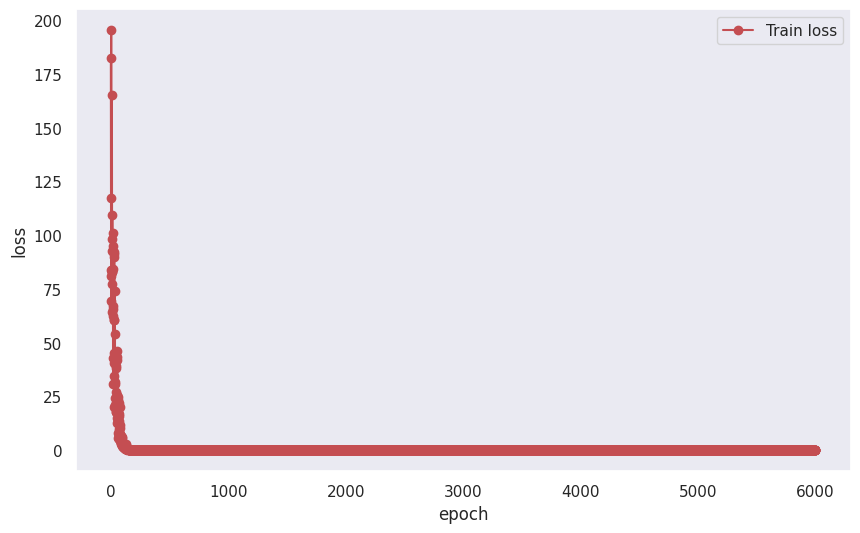

In [13]:

train_loss_all = torch.tensor(train_loss_all, device = 'cpu')
plt.figure(figsize=(10,6))
plt.plot(train_loss_all.cpu().numpy(),"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [14]:
#confidence interval 
#获取样本和标签之间的置信区间关系 找到上下界  判断样本是否在区间内 在阈值内 即打上标签
# samples = 13542
y_samp = np.zeros((samples,1))
for s in range(samples):
    for b_x,b_y  in student_train_loader:
        y = net (b_x[s]).cpu().detach().numpy()
        y_samp[s] = y
# print(y_samp)
lower = np.percentile(y_samp, 2.5, axis = 0)
upper = np.percentile(y_samp, 97.5, axis = 0)
print(f'lower:{lower},upper:{upper}')
#97.5-2.5////99-2

lower:[-0.43367627],upper:[0.44907191]


In [15]:
print(lower,upper)
count = 0 
for i in range(samples):
    for b_x,b_y in student_train_loader:
    #     print(max(b_y),min(b_y)) tensor(5.0000) tensor(0.1500)
    #     print(b_y)
        if lower<=b_y[i].item()<=upper:
            count+=1
print (count,count/samples,samples-count)
#其实只丢了134条数据

[-0.43367627] [0.44907191]
8227 1.0 0


In [12]:
# for b_x,b_y in student_train_loader:
#     print(b_y[0].item())
#     b_y[0]=1
#     print(b_y[0])
# upper=torch.tensor(upper).to(device)
# lower= torch.tensor(lower).to(device)

lower = [-0.43367627]
upper = [0.44907191]
upper=torch.tensor(upper).to(device)
lower= torch.tensor(lower).to(device)
print(lower)
print(upper)

tensor([-0.4337], device='cuda:1')
tensor([0.4491], device='cuda:1')


In [13]:
#teahcer labeling
#聚合标签
from http.cookiejar import LoadError
import random
import numpy as np
mu = 0
# sigma =0.1
# sigma = 0.2
sigma =0.3
# sigma =1
# sigma =0.5

# teacher_best_models =[torch.load(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/teacher{tea_num}/best.pth')  for  tea in  range(n_teachers)]
teacher_best_models =[torch.load(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44_gauss/teacher{tea_num}/best.pth')  for  tea_num in  range(n_teachers)]
# fz1 =torch.zeros(13542,1).to(device)
pos= torch.ones(samples,n_teachers).to(device)
#用0标记无效值 数据集已ln处理 无ln0
# 记录每个老师 针对拿到的数据 预测出来的如果符合置信区间内，那就记录在内，如果不在 则剔除该值
ccc = 0
sss=0
for tea in range(n_teachers):
    for x,y in student_train_loader:
            teacher_best_models[tea].eval().to(device)
            pred=teacher_best_models[tea].forward(x)

            pred+=random.gauss(mu,sigma)
            for i in range(samples):
                # if lower <= pred[i].item() <= upper :

                if lower.item()<= pred[i].item() <= upper.item():
                    #如果在内 记录
                    pos[i][tea]+=pred[i].item()
                    sss+=1
                else:
                    ccc+=1
print(pos,pos.shape,ccc/(sss+ccc))            

#针对pos中有效值（非0数）进行处理  →  每个老师打出标签做均值求和 
res= torch.zeros(samples,1).to(device)
count_data=0
count_sum=0
for i in range(samples):
    for j in range(n_teachers):
        if pos[i][j]!=1:
            count_data+=1
            count_sum+=pos[i][j]
            # 有效
    # if count_data!=0:
    #     cur=count_sum/count_data #data1 +....datan//K
    # else:
    #     cur = count_sum/1
    #     zero+=1#表明n个老师打出的值均无效//避免除以0//零值  但标准化后出现0值 需注意
    if count_data==0:#表明n个老师打出的值均无效//避免除以0//零值
        print('False')
    cur=count_sum/count_data #data1 +....datan//K
    res[i]+=cur#有效的均值标签
    res[i]-=1
print(res)


tensor([[0.7140, 1.0552, 1.0000,  ..., 1.0000, 1.0000, 1.0291],
        [0.7476, 1.0000, 1.0000,  ..., 1.1933, 1.0000, 1.4098],
        [0.7457, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.8480, 0.7983, 0.9003,  ..., 1.0273, 1.0000, 1.0000],
        [1.2426, 1.0982, 0.9232,  ..., 1.3494, 1.0000, 1.0000],
        [1.1311, 0.7740, 0.6945,  ..., 1.2391, 0.7902, 1.3050]],
       device='cuda:1') torch.Size([8227, 10]) 0.4074389206272031
tensor([[0.0211],
        [0.0068],
        [0.0211],
        ...,
        [0.0196],
        [0.0196],
        [0.0196]], device='cuda:1')


In [ ]:
#student_label
student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(res,device=device,dtype=torch.float))
student_train_loader1 = DataLoader(student_trainset,batch_size=batch_size)

: 

In [15]:
#creating student  folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

mkdir_if_missing(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/stu')

In [16]:
# neural network model mlp
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=81, out_features=810, bias=True),
                                  nn.Dropout(0.7),
                                  nn.Tanh()
                                  )
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=810, out_features=162, bias=True),
                                  nn.Dropout(0.7),
                                  nn.Tanh()
                                  )
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=162, out_features=54, bias=True),
                                  nn.Dropout(0.6),
                                  nn.Tanh()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=54, out_features=1, bias=True),
                                        nn.Tanh())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output



mlpreg=MLP().to(device)
print(mlpreg)
# #initialzing student model
student_model=mlpreg
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-5) 

MLP(
  (hidden1): Sequential(
    (0): Linear(in_features=81, out_features=810, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Tanh()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=810, out_features=162, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Tanh()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=162, out_features=54, bias=True)
    (1): Dropout(p=0.6, inplace=False)
    (2): Tanh()
  )
  (predict): Sequential(
    (0): Linear(in_features=54, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [17]:
#train student model
loss_func=nn.MSELoss()
print('start training')
train_loss_all_stu=[]
minloss=float('inf')
for epoch in  range(250):
    train_loss = 0
    train_num=0
    student_model.train()
    for b_x,b_y in  student_train_loader1:
        student_optimizer.zero_grad()
        output=student_model(b_x.to(device))
        loss=loss_func(output,b_y.to(device))
        loss.backward()
        student_optimizer.step()
        train_loss+=loss.item() * b_x.size(0)
        train_num += b_x.size(0)
        loss_stu = train_loss/train_num
        if loss_stu < minloss:
            minloss = loss_stu
            if os.path.exists(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/stu/best1.pth'):
                os.remove(f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/stu/best1.pth')
            torch.save(student_model, f'/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/stu/best1.pth')
    if epoch%1 == 0:
        print(f'student train: Epo:{epoch}  Loss_stu:{loss_stu}')
    train_loss_all_stu.append(loss_stu)      

start training
student train: Epo:0  Loss_stu:0.03242164737009163
student train: Epo:1  Loss_stu:0.02836344466636722
student train: Epo:2  Loss_stu:0.025047746884191806
student train: Epo:3  Loss_stu:0.023204402773721086
student train: Epo:4  Loss_stu:0.0214130647692857
student train: Epo:5  Loss_stu:0.019999945774888145
student train: Epo:6  Loss_stu:0.018985718430733208
student train: Epo:7  Loss_stu:0.01783766329976305
student train: Epo:8  Loss_stu:0.016707443599016925
student train: Epo:9  Loss_stu:0.016213695421883747
student train: Epo:10  Loss_stu:0.015701855180197084
student train: Epo:11  Loss_stu:0.015086472268558524
student train: Epo:12  Loss_stu:0.01446018412675728
student train: Epo:13  Loss_stu:0.013866497471886032
student train: Epo:14  Loss_stu:0.013621626489957512
student train: Epo:15  Loss_stu:0.01309304036380266
student train: Epo:16  Loss_stu:0.01289332702303568
student train: Epo:17  Loss_stu:0.012519336745126635
student train: Epo:18  Loss_stu:0.012096648532396

In [68]:
# 保存
# import numpy as np
# # c=np.array(train_loss_all_stu)
# # np.save('/home/ysy/ysy/Fed-ReKD/44_loss.npy',c)   # 保存为.npy格式

# # c1=np.array(train_loss_all_stu)
# # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_1.npy',c1)   # 保存为.npy格式

# # c2=np.array(train_loss_all_stu)
# # np.save('/home/ysy/ysy/Fed-ReKD/44_loss_2.npy',c2)   # 保存为.npy格式
# c3=np.array(train_loss_all_stu)
# np.save('/home/ysy/ysy/Fed-ReKD/44_loss_3.npy',c3)   # 保存为.npy格式

In [19]:
import numpy as np
# c=np.load('/home/ysy/ysy/Fed-ReKD/44_loss.npy')
# c1=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_1.npy')
# c2=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_2.npy')
# c3=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_3.npy')

# c_average=(c+c1+c2+c3)/4
# np.save('/home/ysy/ysy/Fed-ReKD/44_loss_average.npy',c_average)   # 保存为.npy格式
            # 保存
# import numpy as np
D=np.array(train_loss_all_stu)


# np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.1).npy',d)   # 保存为.npy格式
# np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.2).npy',d)   # 保存为.npy格式

# np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,1).npy',d)   # 保存为.npy格式
# np.save('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.5).npy',d)   # 保存为.npy格式
# 读取





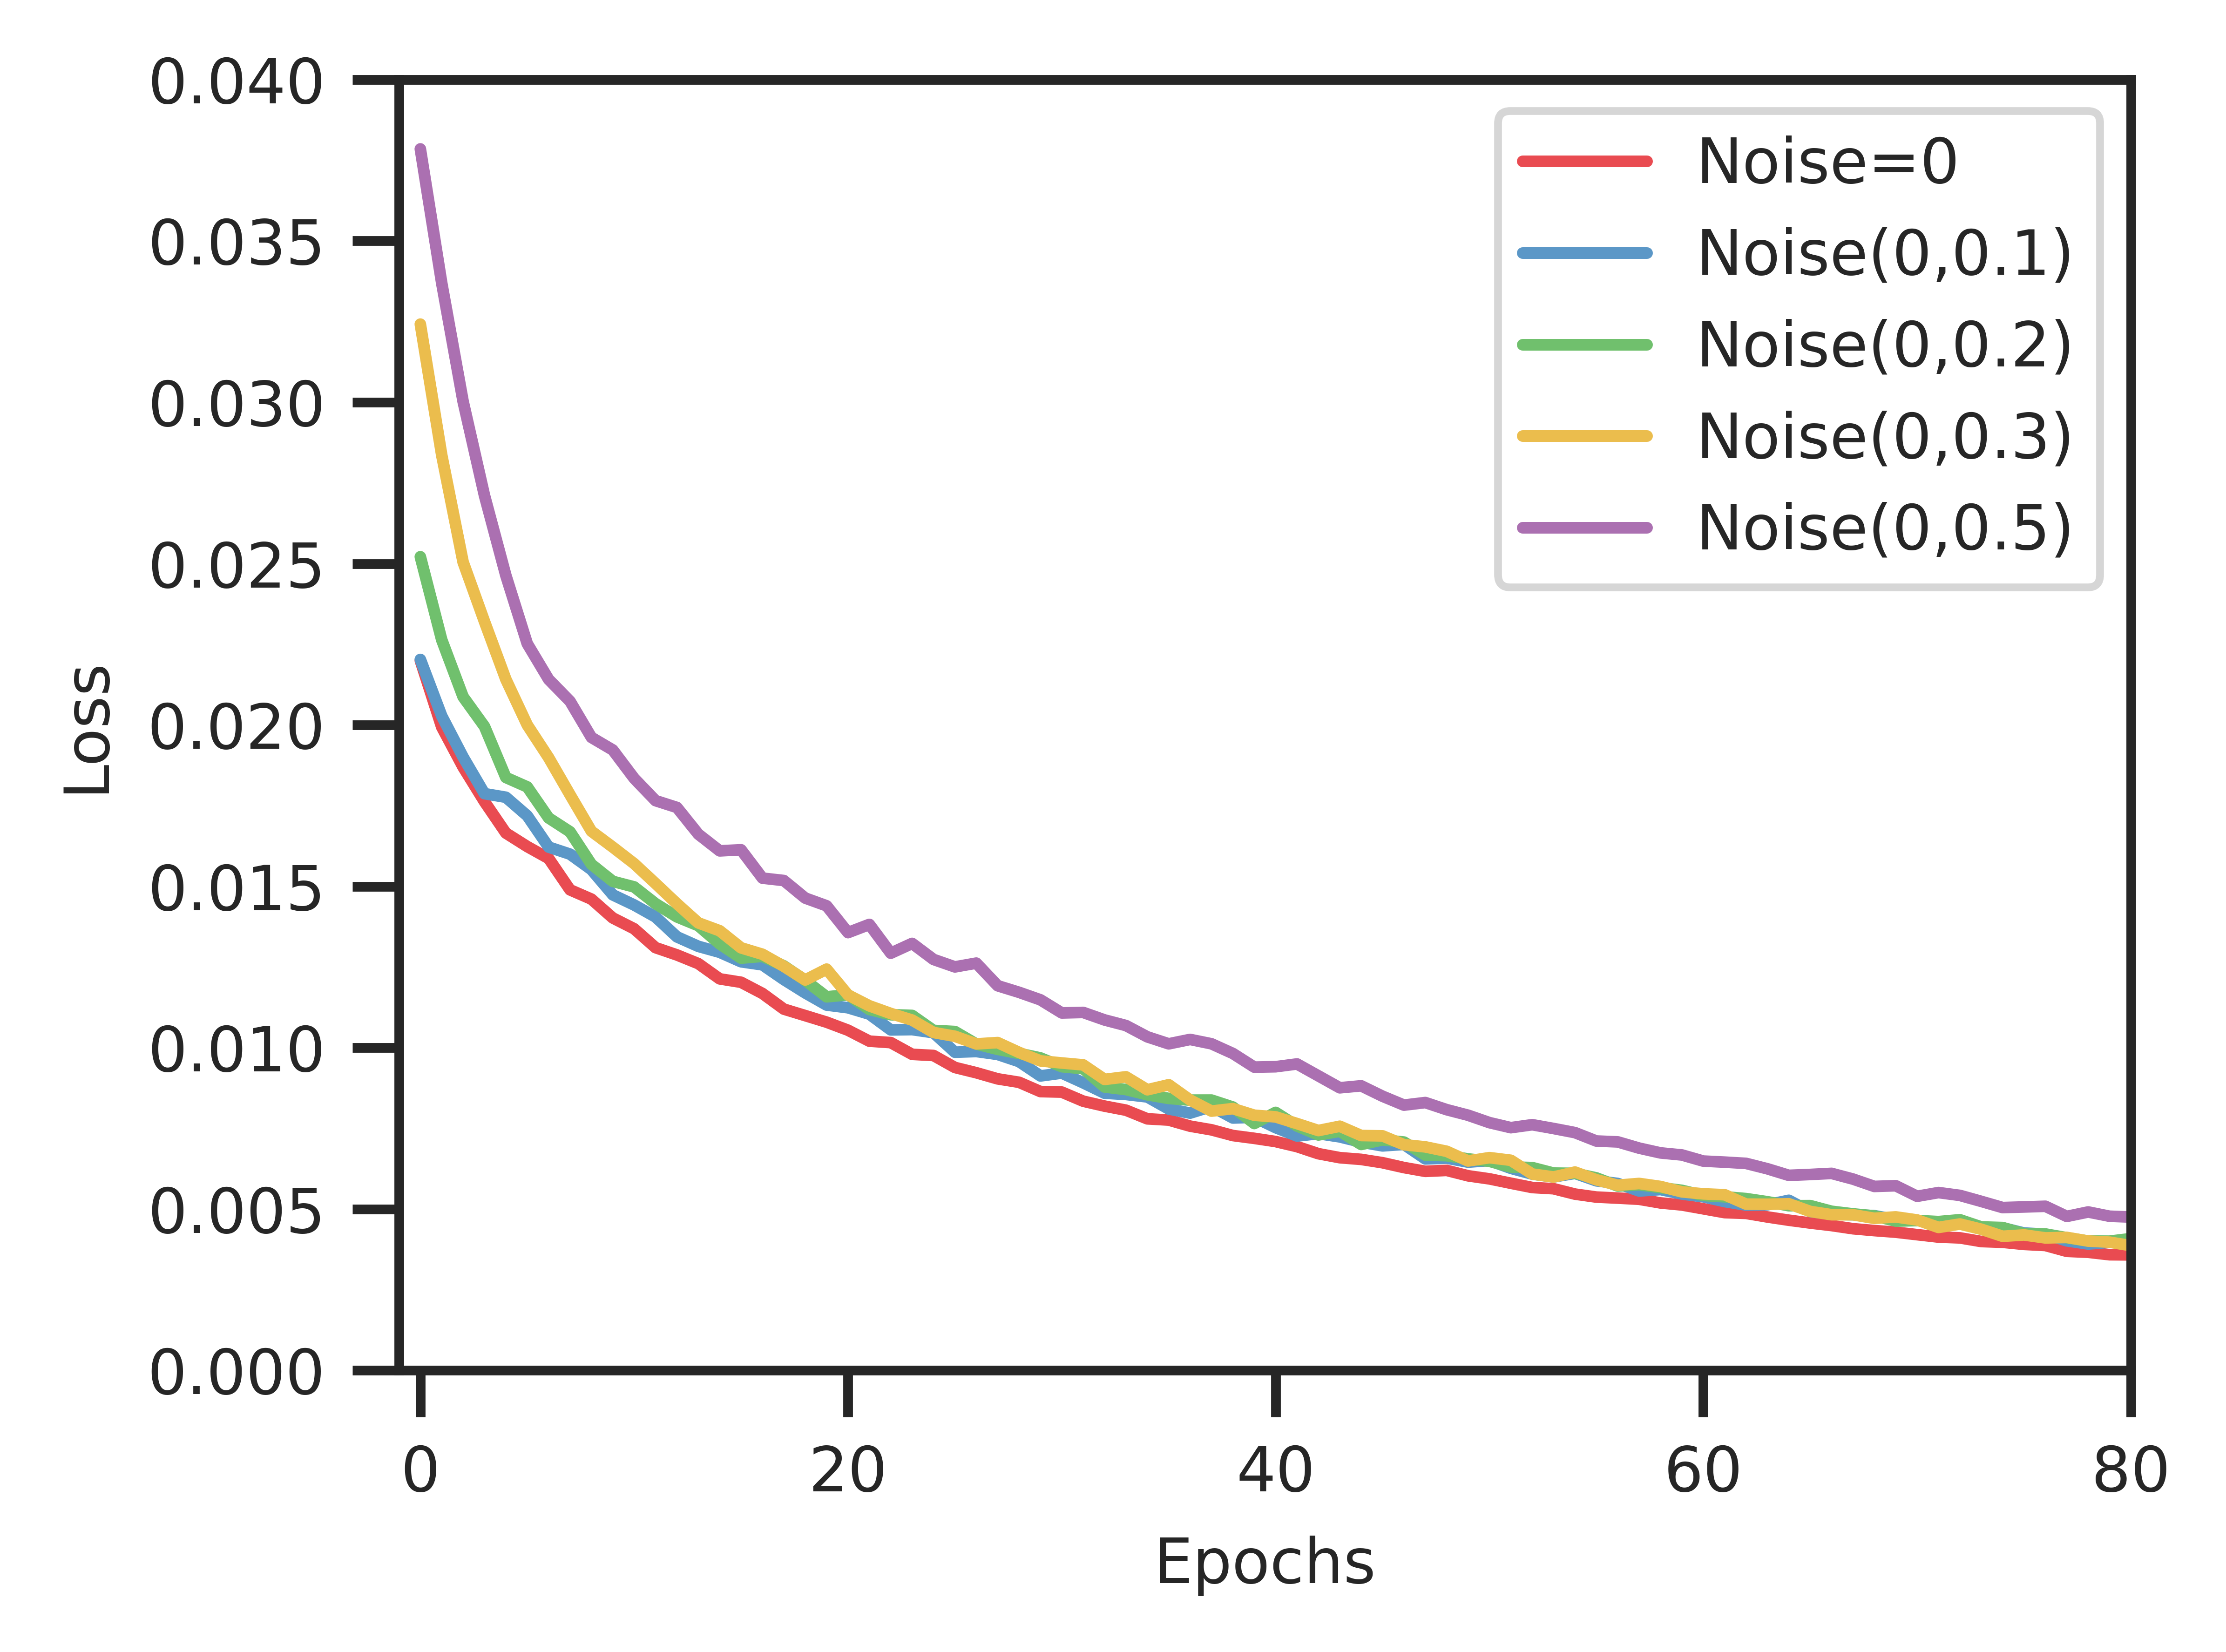

In [49]:

#svg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
from  mpl_toolkits.axisartist import axis_artist

#读取
# c=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_1.npy')
c=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_average.npy')
c=c.tolist()
d1=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.1).npy')
d2=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.2).npy')
d3=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.3).npy')
d4=np.load('/home/ysy/ysy/Fed-ReKD/44_loss_gauss(0,0.5).npy')
d1=d1.tolist()
d2=d2.tolist()
d3=d3.tolist()
d4=d4.tolist()

sns.set_style("ticks")
figure(num=None, figsize=(4, 3), dpi=1200)

plt.plot(c, '#E94B51', label='Noise=0')


plt.plot(d1, '#5B97C7', label='Noise(0,0.1)')
plt.plot(d2, '#70C06D', label='Noise(0,0.2)')
plt.plot(d3, '#EBBD4D', label='Noise(0,0.3)')
plt.plot(d4, '#AB70B1', label='Noise(0,0.5)')
# 画图，并指定颜色

plt.xticks(fontproperties = 'Times New Roman', fontsize=8)
plt.yticks(np.arange(0, 0.41, 0.005), fontproperties = 'Times New Roman', fontsize=8)
# 指定横纵坐标的字体以及字体大小，记住是fontsize不是size。yticks上我还用numpy指定了坐标轴的变化范围。

plt.legend(loc='upper right', prop={'family':'Times New Roman', 'size':8})
# 图上的legend，记住字体是要用prop以字典形式设置的，而且字的大小是size不是fontsize，这个容易和xticks的命令弄混

# plt.title('Zillow Train Performance', fontdict={'family' : 'Times New Roman', 'size':10})
# 指定图上标题的字体及大小

plt.xlabel('Epochs', fontdict={'family' : 'Times New Roman', 'size':8})
plt.ylabel('Loss', fontdict={'family' : 'Times New Roman', 'size':8})
# 指定横纵坐标描述的字体及大小
plt.xlim(-1,80)
plt.ylim(0.00,0.04)


# plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.1).pdf', dpi=1200, bbox_inches="tight")
# plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.2).pdf', dpi=1200, bbox_inches="tight")
# plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.3).pdf', dpi=1200, bbox_inches="tight")
# plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_(0,0.5).pdf', dpi=1200, bbox_inches="tight")

plt.savefig('/home/ysy/ysy/Fed-ReKD/loss_44_all.pdf', dpi=1200, bbox_inches="tight")
plt.show()


In [203]:
#eval  student model
import re


student_best_model =torch.load('/home/ysy/ysy/Fed-ReKD-dirs/BNN_MLP_44/stu/best1.pth')
for s_x,s_y in  student_test_loader:
    student_best_model.eval().to(device)
    pred=student_best_model(s_x)
 

# sy.shape
    loss_test=loss_func(pred,s_y) 
    print(f'student test Loss:{loss_test}',f'\n b_x:{b_x}',f'\n predict:{pred}',f'\n b_y:{s_y}')
# array = y.cpu().numpy()

# print(len(s_x))
#找到置信区间 若在student_test_loader中的x的置信度符合该置信区间的 我就加入到新的测试集中，并加入对应标签。训练取loss
# 给各个地方打上标签，对不熟的标签 进行剔除投票 将原有数据集的y标签进行聚合   关于隐私保护机制/// 拉普拉斯 针对数值型数据 加入独立同分布的高斯噪声  根据噪声与隐私预算 做调整 //指数机制  针对非数值型数据  设置质量函数 选择输出
# 0.025 

student test Loss:0.006680713500827551 
 b_x:tensor([[ 0.1580, -0.0302, -0.1466,  ..., -0.4975, -0.4975, -0.4975],
        [ 0.1580, -0.0302, -0.1466,  ..., -0.4975, -0.4975, -0.4975],
        [ 0.1580, -0.0302, -0.1466,  ...,  2.0099,  2.0099,  2.0099],
        ...,
        [ 0.1580, -0.0302, -0.1466,  ...,  2.0099,  2.0099,  2.0099],
        [ 0.1580, -0.0302, -0.1466,  ...,  2.0099,  2.0099,  2.0099],
        [ 0.1580, -0.0302, -0.1466,  ..., -0.4975, -0.4975, -0.4975]],
       device='cuda:1') 
 predict:tensor([[0.0048],
        [0.0056],
        [0.0050],
        ...,
        [0.0047],
        [0.0048],
        [0.0049]], device='cuda:1', grad_fn=<TanhBackward0>) 
 b_y:tensor([ 0.0583,  0.0816,  0.0564,  ..., -0.0866,  0.0080, -0.0956],
       device='cuda:1')


In [205]:
class Account:
    __Account=0.1
    def __init__(self,owner,amount):
        self.owner=owner
        self.__amount=amount
    def __get_info(self):
        return " {0},{1},{2}".format(self.owner,self.__amount,Account.__Account)
    def sec(self):
        print(self.__get_info())

A=Account('T',1)
A.sec()#调用实例方法，从而访问类内私有变量  __



 T,1,0.1
